# Proyecto 04 - Reconocimiento de lenguaje de señas

## **Dataset**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import nn
import torch.optim as optim
import optuna
import torch.nn.functional as F

### X_data: Matriz de Imágenes

In [7]:
#load
data_test = pd.read_csv('.\data\sign_mnist_test.csv')
data_train = pd.read_csv('.\data\sign_mnist_train.csv')


In [9]:
scaler = MinMaxScaler()


X_train = data_train.iloc[:, 1:].values 
X_test = data_test.iloc[:, 1:].values

X_train = scaler.fit_transform(X_train) # Normalizando los datos
X_test = scaler.fit_transform(X_test) # Normalizando los datos

X_train = torch.from_numpy(X_train).float() # Convirtiendo a tensor
X_test = torch.from_numpy(X_test).float() # Convirtiendo a tensor



In [10]:
print("Cantidad de pixeles: ", data_test.shape[1]-1)
print("Tamaño de cada imagen: ", np.sqrt(data_test.shape[1]-1), " x ", np.sqrt(data_test.shape[1]-1))
print("Cantidad de imagenes de entrenamiento: ", data_train.shape[0])

Cantidad de pixeles:  784
Tamaño de cada imagen:  28.0  x  28.0
Cantidad de imagenes de entrenamiento:  27455


### Label: etiqueta de cada imagen

In [11]:
y_train = data_train.iloc[:, 0].values
y_test = data_test.iloc[:, 0].values

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

np.sort(np.sort(data_train['label'].unique()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

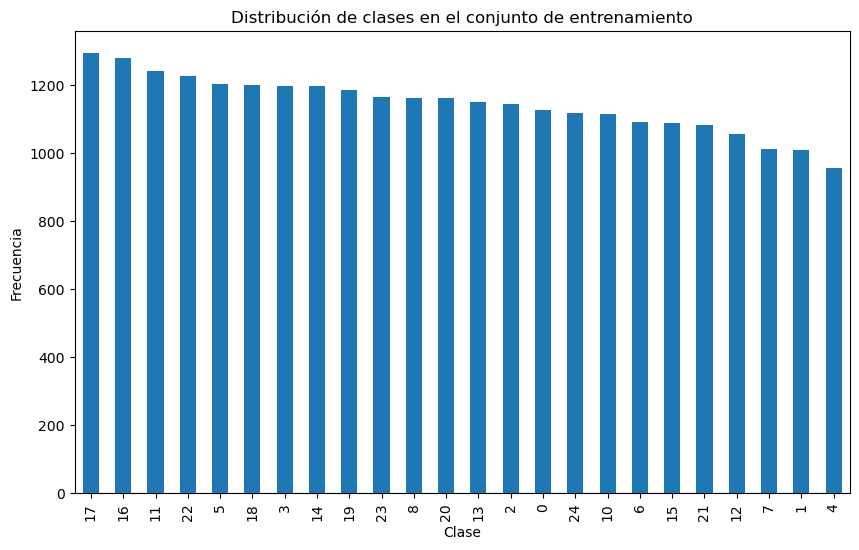

In [12]:
# Conteo de frecuencias de cada clase
train_label_counts = data_train['label'].value_counts()

plt.figure(figsize=(10, 6))
train_label_counts.plot(kind='bar')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

Cada numero representa una letra del abecedario en lenguaje de señas americano (ASL), donde 0 es la letra A y 25 es la letra Z. Debido a que la seña de la letra J=9 y Z=25 requieren movimiento, estas señas se excluyeron del dataset.

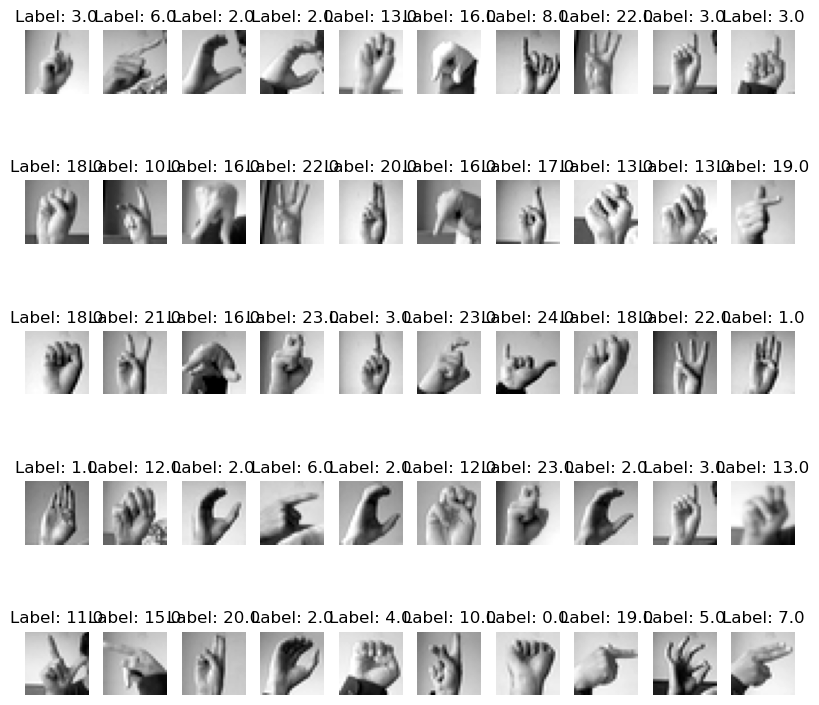

In [13]:
# Crear un mosaico de imágenes
n_rows = 5
n_cols = 10
plt.figure(figsize=(8, 8))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = X_train[i].reshape(28, 28)  # Remodelar a 28x28
    label = y_train[i]
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **MLP**

In [40]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size, activation_function, dropout_rate=0.2):
        super(MLP, self).__init__()
        activation_functions = {
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh(),
            "relu": nn.ReLU()
        }

        if activation_function.lower() not in activation_functions:
            raise ValueError(f"Unsupported activation function: {activation_function}")

        self.activation_function = activation_functions[activation_function.lower()]

        layers = []
        # Input Layer
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(self.activation_function)


        # Hidden Layers
        for i in range(hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(self.activation_function)
            layers.append(nn.Dropout(dropout_rate))  # Adding dropout to hidden layers


        # Output Layer
        layers.append(nn.Linear(neurons_per_layer, output_size))


        self.layers = nn.Sequential(*layers)
        self.loss_history = None

    def forward(self, x):
      output = self.layers(x)
      return output

    def fit(self, X_train, Y_train, epochs=1000, learning_rate=0.001):
        loss_function = nn.CrossEntropyLoss() #Internally use Softmax function
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        loss_history = []

        for epoch in range(epochs):
          Y_pred = self.forward(X_train)
          loss = loss_function(Y_pred,Y_train.long())
          loss_history.append(loss.item())
          if (epoch%100==0):
            print(f"Epoch {epoch}: train loss: {loss.item()}")

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        self.loss_history = loss_history

    def predict(self, X_test):
        self.eval()

        with torch.no_grad():  # Deactive gradient calc for interference
            Y_pred = self.forward(X_test)

        probs = torch.softmax(Y_pred, dim=1)  # Apply softmax function

        labels = torch.argmax(probs, dim=1)  # Get class with best probability
        return labels

In [41]:
def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 70, 100)
    input_size = X_train.shape[1]
    output_size = 25
    activation_function = 'relu'

    model = MLP(input_size, hidden_layers, neurons_per_layer, output_size, activation_function)
    model.fit(X_train, y_train)

    # Evalúa el modelo en el conjunto de validación
    predictions = model.predict(X_test)
    accuracy = torch.sum(predictions == y_test).item() / len(y_test)

    return accuracy

# Crea un estudio de Optuna y optimiza la función objetivo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprime los resultados de la optimización
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print(f'Hiperparámetros óptimos: {trial.params}')

[I 2023-11-27 21:54:36,711] A new study created in memory with name: no-name-5dfed723-b122-4539-a1cf-a23b280ca872


Epoch 0: train loss: 3.217435359954834
Epoch 100: train loss: 2.0912907123565674
Epoch 200: train loss: 1.6192771196365356
Epoch 300: train loss: 1.3605856895446777
Epoch 400: train loss: 1.1570591926574707
Epoch 500: train loss: 1.0429885387420654
Epoch 600: train loss: 0.8757362961769104
Epoch 700: train loss: 0.7744922041893005
Epoch 800: train loss: 0.6637311577796936
Epoch 900: train loss: 0.5537182688713074


[I 2023-11-27 22:00:04,059] Trial 0 finished with value: 0.6372002230897936 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 78}. Best is trial 0 with value: 0.6372002230897936.


Epoch 0: train loss: 3.2192490100860596
Epoch 100: train loss: 2.167479991912842
Epoch 200: train loss: 1.476392388343811
Epoch 300: train loss: 1.2100205421447754
Epoch 400: train loss: 0.9508260488510132
Epoch 500: train loss: 0.7672293186187744
Epoch 600: train loss: 0.6313570141792297
Epoch 700: train loss: 0.523566722869873
Epoch 800: train loss: 1.5905944108963013
Epoch 900: train loss: 0.7841194868087769


[I 2023-11-27 22:05:47,459] Trial 1 finished with value: 0.6176798661461238 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 99}. Best is trial 0 with value: 0.6372002230897936.


Epoch 0: train loss: 3.2177674770355225
Epoch 100: train loss: 1.8887048959732056
Epoch 200: train loss: 1.4242885112762451
Epoch 300: train loss: 1.1646991968154907
Epoch 400: train loss: 0.9980192184448242
Epoch 500: train loss: 0.8800116777420044
Epoch 600: train loss: 0.7715071439743042
Epoch 700: train loss: 0.6704890131950378
Epoch 800: train loss: 0.613245964050293
Epoch 900: train loss: 0.6367154717445374


[I 2023-11-27 22:10:17,504] Trial 2 finished with value: 0.589654210819855 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 89}. Best is trial 0 with value: 0.6372002230897936.


Epoch 0: train loss: 3.2250888347625732
Epoch 100: train loss: 1.6366556882858276
Epoch 200: train loss: 1.1041259765625
Epoch 300: train loss: 0.7949009537696838
Epoch 400: train loss: 0.6154946088790894
Epoch 500: train loss: 0.48356032371520996
Epoch 600: train loss: 0.38824453949928284
Epoch 700: train loss: 0.3133573830127716
Epoch 800: train loss: 0.26444584131240845
Epoch 900: train loss: 0.21430912613868713


[I 2023-11-27 22:13:23,052] Trial 3 finished with value: 0.7162576687116564 and parameters: {'hidden_layers': 2, 'neurons_per_layer': 90}. Best is trial 3 with value: 0.7162576687116564.


Epoch 0: train loss: 3.2232043743133545
Epoch 100: train loss: 2.1166703701019287
Epoch 200: train loss: 1.5572843551635742
Epoch 300: train loss: 1.3235312700271606
Epoch 400: train loss: 0.9673813581466675
Epoch 500: train loss: 0.7965273261070251
Epoch 600: train loss: 0.8245964050292969
Epoch 700: train loss: 0.7726739645004272
Epoch 800: train loss: 0.49303004145622253
Epoch 900: train loss: 1.2870508432388306


[I 2023-11-27 22:18:10,709] Trial 4 finished with value: 0.6636921360847742 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 98}. Best is trial 3 with value: 0.7162576687116564.


Epoch 0: train loss: 3.2332797050476074
Epoch 100: train loss: 1.4819161891937256
Epoch 200: train loss: 0.8990209698677063
Epoch 300: train loss: 0.6044390201568604
Epoch 400: train loss: 0.42708146572113037
Epoch 500: train loss: 0.3180792033672333
Epoch 600: train loss: 0.23960794508457184
Epoch 700: train loss: 0.18825986981391907
Epoch 800: train loss: 0.14203301072120667
Epoch 900: train loss: 0.1183554083108902


[I 2023-11-27 22:21:10,844] Trial 5 finished with value: 0.748047964305633 and parameters: {'hidden_layers': 1, 'neurons_per_layer': 95}. Best is trial 5 with value: 0.748047964305633.


Epoch 0: train loss: 3.2269556522369385
Epoch 100: train loss: 2.1704723834991455
Epoch 200: train loss: 1.6156917810440063
Epoch 300: train loss: 1.3018953800201416
Epoch 400: train loss: 1.065419316291809
Epoch 500: train loss: 0.900002121925354
Epoch 600: train loss: 0.7861843109130859
Epoch 700: train loss: 0.7037973403930664
Epoch 800: train loss: 0.6183227300643921
Epoch 900: train loss: 0.6890795230865479


[I 2023-11-27 22:25:18,526] Trial 6 finished with value: 0.6609035136642498 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 78}. Best is trial 5 with value: 0.748047964305633.


Epoch 0: train loss: 3.219411611557007
Epoch 100: train loss: 2.221003532409668
Epoch 200: train loss: 1.6981600522994995
Epoch 300: train loss: 1.4198501110076904
Epoch 400: train loss: 1.6350955963134766
Epoch 500: train loss: 1.1046971082687378
Epoch 600: train loss: 1.0111558437347412
Epoch 700: train loss: 0.8709457516670227
Epoch 800: train loss: 0.7799071073532104
Epoch 900: train loss: 1.3769925832748413


[I 2023-11-27 22:29:40,360] Trial 7 finished with value: 0.587005019520357 and parameters: {'hidden_layers': 5, 'neurons_per_layer': 70}. Best is trial 5 with value: 0.748047964305633.


Epoch 0: train loss: 3.2152371406555176
Epoch 100: train loss: 1.660949468612671
Epoch 200: train loss: 1.1472206115722656
Epoch 300: train loss: 0.8532490134239197
Epoch 400: train loss: 0.646025538444519
Epoch 500: train loss: 0.5474573373794556
Epoch 600: train loss: 0.4155246615409851
Epoch 700: train loss: 0.3488076329231262
Epoch 800: train loss: 0.2805713713169098
Epoch 900: train loss: 0.22759661078453064


[I 2023-11-27 22:32:56,983] Trial 8 finished with value: 0.72643614054657 and parameters: {'hidden_layers': 2, 'neurons_per_layer': 82}. Best is trial 5 with value: 0.748047964305633.


Epoch 0: train loss: 3.2215375900268555
Epoch 100: train loss: 1.9196957349777222
Epoch 200: train loss: 1.4383957386016846
Epoch 300: train loss: 1.1836366653442383
Epoch 400: train loss: 1.0133317708969116
Epoch 500: train loss: 0.932100772857666
Epoch 600: train loss: 0.7020860314369202
Epoch 700: train loss: 0.685117781162262
Epoch 800: train loss: 0.5296962857246399
Epoch 900: train loss: 1.1793047189712524


[I 2023-11-27 22:37:34,370] Trial 9 finished with value: 0.5812883435582822 and parameters: {'hidden_layers': 4, 'neurons_per_layer': 83}. Best is trial 5 with value: 0.748047964305633.


Best trial:
Accuracy: 0.748047964305633
Hiperparámetros óptimos: {'hidden_layers': 1, 'neurons_per_layer': 95}


In [73]:
# Replicate results with best hyperparameters
input_size = X_train.shape[1]
hidden_layers = trial.params['hidden_layers']
neurons_per_layer = trial.params['neurons_per_layer']
output_size = 25
activation_function = 'relu'

model = MLP(input_size, hidden_layers, neurons_per_layer, output_size, activation_function)

In [74]:
model.fit(X_train, y_train)

Epoch 0: train loss: 3.2257766723632812
Epoch 100: train loss: 1.523289680480957
Epoch 200: train loss: 0.9061386585235596
Epoch 300: train loss: 0.6097113490104675
Epoch 400: train loss: 0.43150413036346436
Epoch 500: train loss: 0.31953033804893494
Epoch 600: train loss: 0.2391190528869629
Epoch 700: train loss: 0.18104702234268188
Epoch 800: train loss: 0.14325004816055298
Epoch 900: train loss: 0.11577848345041275


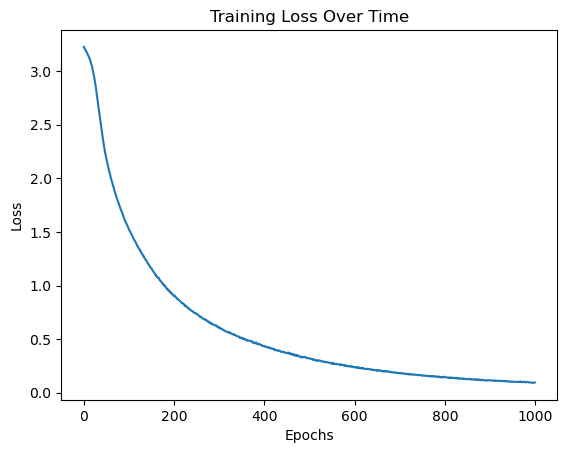

Accuracy: 74.04%


In [75]:
# Graficar la pérdida
plt.plot(model.loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

def calculate_accuracy(model, X_test, Y_test):
    predictions = model.predict(X_test)

    if not isinstance(predictions, np.ndarray):
        predictions = predictions.numpy()
    if not isinstance(Y_test, np.ndarray):
        Y_test = Y_test.numpy()

    correct = (predictions == Y_test).sum().item()
    total = len(Y_test)
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [76]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Real Label': y_test, 'Predicted Label': predictions.numpy()})

print(comparison)

      Real Label  Predicted Label
0            6.0                6
1            5.0                5
2           10.0               10
3            0.0                0
4            3.0                3
...          ...              ...
7167         1.0               20
7168        12.0               18
7169         2.0                2
7170         4.0                4
7171         2.0                2

[7172 rows x 2 columns]


In [77]:
class_report = classification_report(y_test, predictions)
print('Classification Report:\n', class_report)



Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.94      0.86       331
         1.0       0.91      0.90      0.90       432
         2.0       0.95      0.93      0.94       310
         3.0       0.97      0.84      0.90       245
         4.0       0.82      0.91      0.86       498
         5.0       0.72      0.91      0.81       247
         6.0       0.79      0.71      0.75       348
         7.0       0.85      0.81      0.83       436
         8.0       0.66      0.85      0.74       288
        10.0       0.67      0.53      0.59       331
        11.0       0.74      0.99      0.85       209
        12.0       0.71      0.52      0.60       394
        13.0       0.74      0.49      0.59       291
        14.0       0.93      0.82      0.87       246
        15.0       0.99      0.98      0.98       347
        16.0       0.64      0.74      0.69       164
        17.0       0.43      0.58      0.49       144
   

In [78]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix)
print('Confusion Matrix:\n', conf_matrix_df)


Confusion Matrix:
      0    1    2    3    4    5    6    7    8    9   ...   14   15  16   17  \
0   310    0    0    0    0    0    0    0    0    0  ...    0    0   0    0   
1     0  387    0    0    0    0    0    0    0    0  ...    0    0   0    0   
2     0    0  289    0    0   21    0    0    0    0  ...    0    0   0    0   
3     0    9    0  205    0    0    0    0    0    5  ...    0    0   5    0   
4     0    0    0    0  454    0    0    0    0    0  ...    0    0   0   44   
5     0    0   15    0    0  226    0    0    0    0  ...    0    0   0    0   
6     0    0    0    0    0    0  248   40    0    0  ...    0   41   0    0   
7     0   21    0    0    0    0   39  355    0    0  ...    0    0   0    0   
8     0    0    0    0    0    2    0    0  246    0  ...    0    0   8    0   
9     0    0    0    0    0   19    0    0    0  177  ...    0    0  62    0   
10    0    0    0    0    0    0    0    0    0    0  ...    0    0   0    0   
11   14    0    0    

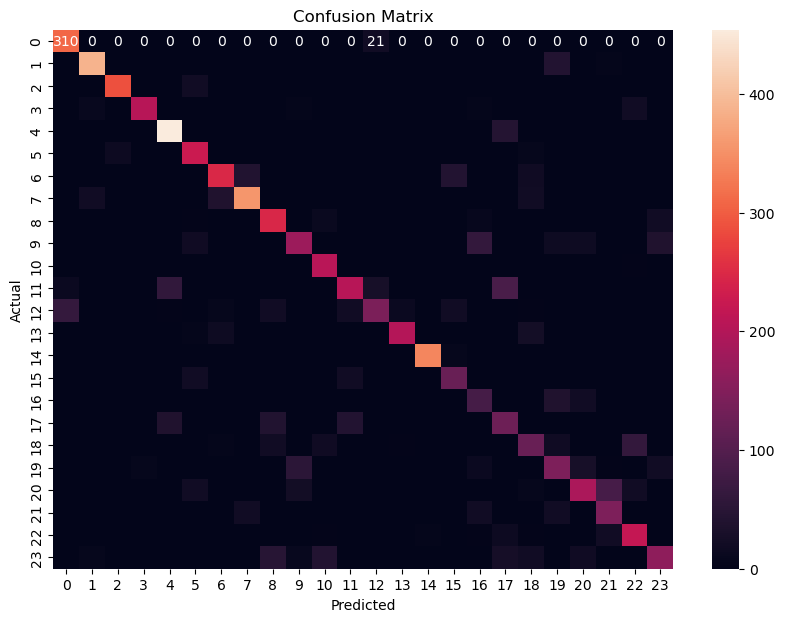

In [79]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


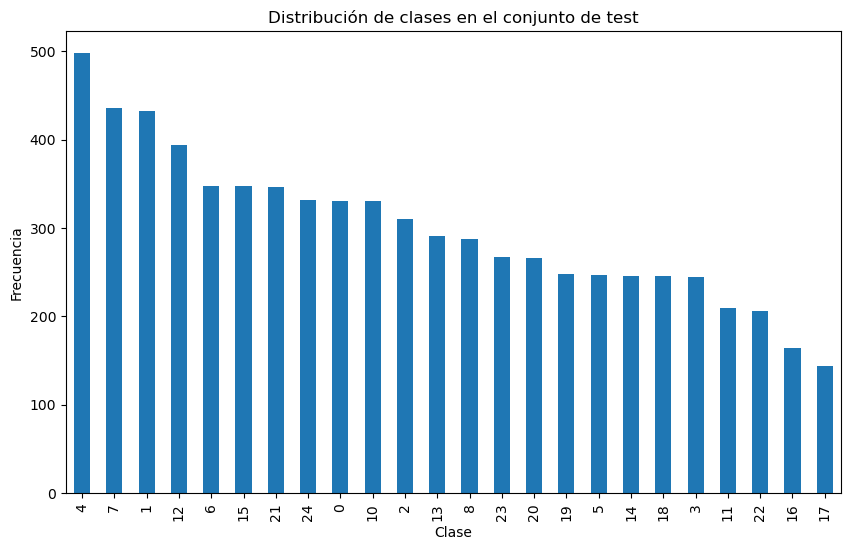

In [102]:
# Conteo de frecuencias de cada clase
train_label_counts = data_test['label'].value_counts()

plt.figure(figsize=(10, 6))
train_label_counts.plot(kind='bar')
plt.title('Distribución de clases en el conjunto de test')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [93]:
from imblearn.over_sampling import SMOTE

# Inicializar SMOTE
smote = SMOTE()

# Ajustar y aplicar el sobremuestreo
X_resampled, y_resampled = smote.fit_resample(X_test, y_test)

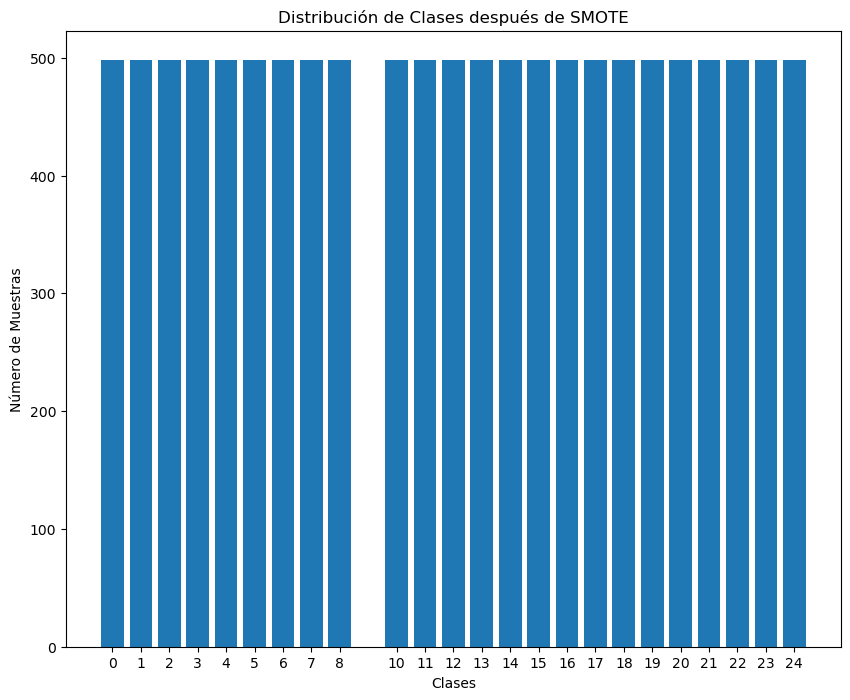

In [96]:
from collections import Counter

# Obtener la distribución de clases en y_resampled
class_distribution = Counter(y_resampled)

# Desempacar las clases y sus respectivos conteos
classes, counts = zip(*class_distribution.items())

# Crear un gráfico de barras
plt.figure(figsize=(10, 8))
plt.bar(classes, counts)

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Clases después de SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')

# Mostrar las etiquetas de las clases en el eje x, si son números se mostrarán directamente
plt.xticks(classes)

# Mostrar el gráfico
plt.show()


In [97]:
print(X_resampled.shape)
print(y_resampled.shape)

(11952, 784)
(11952,)


In [98]:
X_resampled = torch.from_numpy(X_resampled).float()
y_resampled = torch.from_numpy(y_resampled).float()

In [99]:
predictions = model.predict(X_resampled)

comparison = pd.DataFrame({'Real Label': y_resampled, 'Predicted Label': predictions.numpy()})

print(comparison)

       Real Label  Predicted Label
0             6.0                6
1             5.0                5
2            10.0               10
3             0.0                0
4             3.0                3
...           ...              ...
11947        24.0               24
11948        24.0               24
11949        24.0               10
11950        24.0                8
11951        24.0               18

[11952 rows x 2 columns]


In [100]:
accuracy = accuracy_score(y_resampled, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7366967871485943


## **CNN**

In [59]:
class CNN(nn.Module):
    def __init__(self, input_size, kernel_size, conv_pool_layers, in_channels, out_channels_increment, pool_size, stride, padding
                 , hidden_layers, neurons_per_layer, output_size, activation_function):
        super(CNN, self).__init__()
        
        # Parámetros para las capas de convolución y pooling
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        self.conv_pool_layers = conv_pool_layers
        self.input_size = input_size
        
        self.conv_layers = nn.ModuleList()
        current_in_channels = in_channels
        current_out_channels = in_channels*out_channels_increment

        for i in range(conv_pool_layers):
            conv_layer = nn.Conv2d(current_in_channels, current_out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            self.conv_layers.append(conv_layer)
            current_in_channels = current_out_channels
            current_out_channels = current_out_channels*out_channels_increment

            # Añadir una capa de pooling
            pool_layer = nn.MaxPool2d(kernel_size=pool_size)
            self.conv_layers.append(pool_layer)

        # Calcular el tamaño de salida después de la convolución y el pooling
        output_after_conv = self.calculate_output_size()
        
        # Capa MLP
        self.mlp = MLP(output_after_conv*output_after_conv*current_in_channels, hidden_layers, neurons_per_layer, output_size, activation_function)

    def calculate_output_size(self): #Solo para imagenes cuadradas
        output_size = self.input_size
        
        for _ in range(self.conv_pool_layers):
            output_size = (output_size - self.kernel_size + 2 * self.padding) // self.stride + 1
            output_size = (output_size - self.pool_size) // self.pool_size + 1
        
        return output_size
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # -1 mantiene el tamaño del lote, 1 es el número de canales

        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv2d):
                x = F.relu(layer(x))
            else:
                x = layer(x)
        
        x = torch.flatten(x, start_dim=1)
        output = self.mlp.forward(x)
        return output


    def fit(self, X_train, Y_train, epochs=1000, learning_rate=0.001):
        # Definir el optimizador y la función de pérdida
        loss_function = nn.CrossEntropyLoss() #Internally use Softmax function
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        loss_history = []

        for epoch in range(epochs):
            Y_pred = self.forward(X_train)

            loss = loss_function(Y_pred,Y_train.long())
            loss_history.append(loss.item())

            if (epoch%100==0):
                print(f"Epoch {epoch}: train loss: {loss.item()}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        self.loss_history = loss_history

    
    def predict(self, X_test):
        self.eval()

        with torch.no_grad():  # Deactive gradient calc for interference
            Y_pred = self.forward(X_test)

        probs = torch.softmax(Y_pred, dim=1)  # Apply softmax function

        labels = torch.argmax(probs, dim=1)  # Get class with best probability
        return labels

## **Entrenamiento**

In [62]:
input_size = 28 # Tamaño de entrada (por ejemplo, imágenes de 28x28)
kernel_size = 3
pool_size = 2
stride = 1
padding = 1
conv_pool_layers = 1
in_channels = 1
out_channels_increment = 2

hidden_layers = trial.params['hidden_layers']
neurons_per_layer = trial.params['neurons_per_layer']
output_size = 25
activation_function = 'relu'

model = CNN(input_size, kernel_size, conv_pool_layers, in_channels, out_channels_increment, pool_size, stride, padding
                 , hidden_layers, neurons_per_layer, output_size, activation_function)

In [63]:
model.fit(X_train, y_train)

Epoch 0: train loss: 3.219529390335083
Epoch 100: train loss: 1.5648659467697144
Epoch 200: train loss: 0.7121186852455139
Epoch 300: train loss: 0.41457217931747437
Epoch 400: train loss: 0.2593177556991577
Epoch 500: train loss: 0.16612286865711212
Epoch 600: train loss: 0.10766378045082092
Epoch 700: train loss: 0.07589813321828842
Epoch 800: train loss: 0.055949486792087555
Epoch 900: train loss: 0.045086994767189026


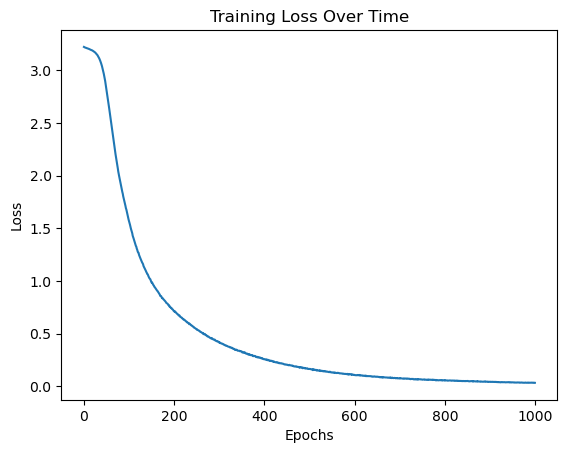

Accuracy: 75.73%


In [64]:
# Graficar la pérdida
plt.plot(model.loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

def calculate_accuracy(model, X_test, Y_test):
    predictions = model.predict(X_test)

    if not isinstance(predictions, np.ndarray):
        predictions = predictions.numpy()
    if not isinstance(Y_test, np.ndarray):
        Y_test = Y_test.numpy()

    correct = (predictions == Y_test).sum().item()
    total = len(Y_test)
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [65]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Real Label': y_test, 'Predicted Label': predictions.numpy()})

print(comparison)

      Real Label  Predicted Label
0            6.0                6
1            5.0                5
2           10.0               10
3            0.0                0
4            3.0               17
...          ...              ...
7167         1.0                1
7168        12.0               13
7169         2.0                2
7170         4.0                4
7171         2.0                2

[7172 rows x 2 columns]


In [69]:
class_report = classification_report(y_test, predictions)
print('Classification Report:\n', class_report)



Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       331
         1.0       0.96      0.94      0.95       432
         2.0       0.87      0.93      0.90       310
         3.0       0.86      0.72      0.78       245
         4.0       0.88      0.95      0.91       498
         5.0       0.95      0.91      0.93       247
         6.0       0.77      0.63      0.69       348
         7.0       0.85      0.81      0.83       436
         8.0       0.67      0.77      0.72       288
        10.0       0.79      0.57      0.67       331
        11.0       0.59      0.80      0.68       209
        12.0       0.85      0.52      0.65       394
        13.0       0.66      0.47      0.55       291
        14.0       0.82      0.67      0.74       246
        15.0       0.90      1.00      0.95       347
        16.0       0.62      0.75      0.68       164
        17.0       0.56      0.72      0.63       144
   

In [70]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix)
print('Confusion Matrix:\n', conf_matrix_df)


Confusion Matrix:
      0    1    2    3    4    5    6    7    8    9   ...   14   15   16   17  \
0   331    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1     0  408    0    4    0    0    0    0    0    0  ...    0    0    0    0   
2     0    0  289    0    0    0    0    0    0    0  ...    0    0    0    0   
3     0    0    0  176    0    0    0    0    0    0  ...    0    0   30    0   
4     0    0    0    0  473    0    0    0    0    0  ...    0    0    0   24   
5     0    0    0    0    0  226    0    0    0    0  ...    0    0    0    0   
6     0    0    0    0    0    0  218   37    0    0  ...    1   40    0    0   
7    14    0    0    0    0    0   37  352    0    0  ...    7    0    0    0   
8    12    0    0    0    0    0    0    0  222    0  ...    0    0   21    0   
9     0    0    0    0    0    5   13    0   21  190  ...   14    0   21    2   
10    0    0   21    0    0    0    0    0    0    0  ...    0    0    0    0   
11    0  

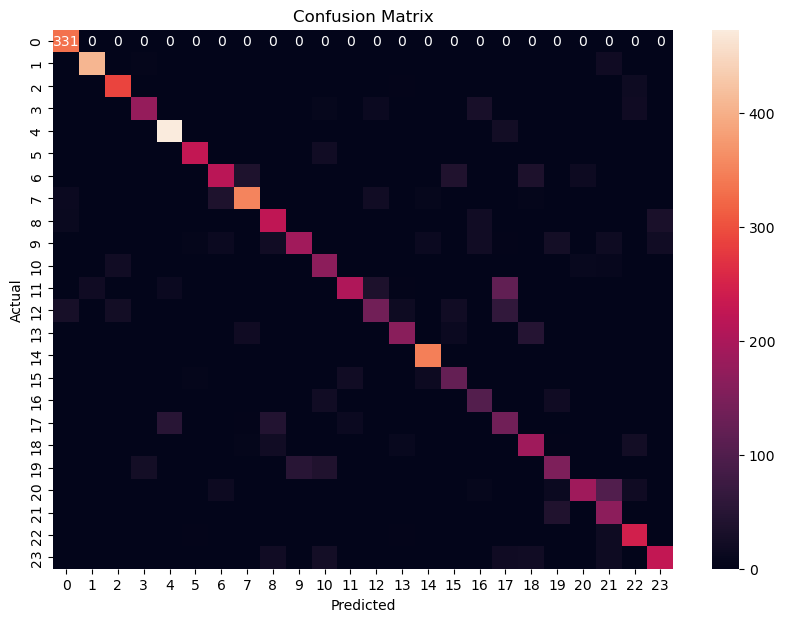

In [71]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
